In [2]:
from io import StringIO

from pathlib import Path
import pandas
import numpy
import matplotlib.pyplot as plt


In [16]:
outdir = Path("./nomographs/volume")
outdir.mkdir(parents=True, exist_ok=True)
outdirqa = Path("./qa/volume")
outdirqa.mkdir(parents=True, exist_ok=True)

In [4]:
volume_paths = list(Path("./data/volume").glob('*.csv'))
volume_paths

[WindowsPath('data/volume/1980s_Hist_Results.csv'),
 WindowsPath('data/volume/2030s_Early_Results.csv'),
 WindowsPath('data/volume/2050s_Mid_Results.csv'),
 WindowsPath('data/volume/2080s_Late_Results.csv')]

In [5]:
def create_met_dataframe() -> pandas.DataFrame:

    string = """
epoch	mean_annual_precip_depth_inches	design_storm_precip_depth_inches	ro_coeff
1980s	35.539	0.652	0.450
2030s	35.982	0.715	0.468
2050s	40.338	0.759	0.495
2080s	38.060	0.800	0.505
"""

    df = pandas.read_table(StringIO(string))

    return df

met = (
    create_met_dataframe()
    .assign(area_acres = 50) # per jamie feldman and sarah welsh
    .assign(design_storm_volume_cuft = lambda df: (

        df['ro_coeff'] 
        * df['area_acres'] * 43560 # acres to sqft
        * df['design_storm_precip_depth_inches'] / 12 # inches to ft
        
        )
    )
)

In [6]:
met

,epoch,mean_annual_precip_depth_inches,design_storm_precip_depth_inches,ro_coeff,area_acres,design_storm_volume_cuft
0,1980s,35.539,0.652,0.450,50,53252.1000
1,2030s,35.982,0.715,0.468,50,60733.5300
2,2050s,40.338,0.759,0.495,50,68190.4575
3,2080s,38.060,0.800,0.505,50,73326.0000


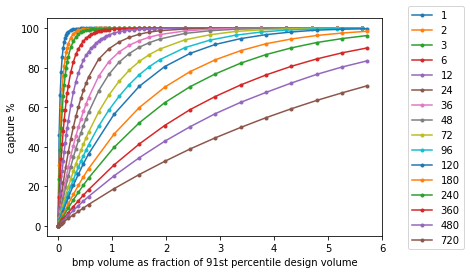

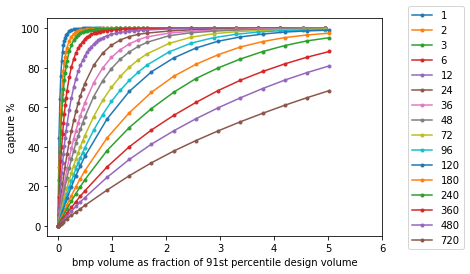

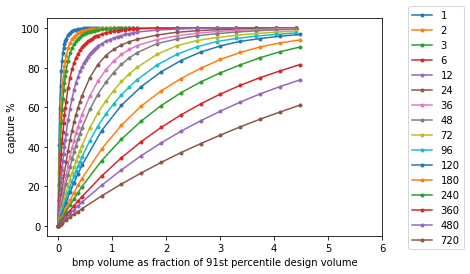

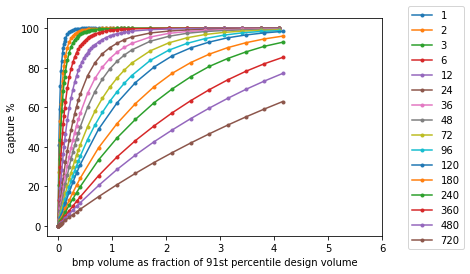

In [18]:
for f, (i, row) in zip(volume_paths, met.iterrows()):
    df = pandas.read_csv(f)
    assert f.stem.split("_")[0] == row.epoch

    df['design_storm_volume_cuft'] = row.design_storm_volume_cuft
    df['vol_cuft'] = df['Vol_cf']
    df['size_fraction'] = df['vol_cuft'] / df['design_storm_volume_cuft']
    df['ddt_hr'] = df['DDT_hr']
    df['capture_fraction'] = numpy.clip( df['Capture_Efficiency_%'] / 100, 0, 1.0) 
    nulls = df['ddt_hr'].drop_duplicates().to_frame()
    nulls['size_fraction'] = 0
    nulls['capture_fraction'] = 0

    df = pandas.concat([df, nulls], ignore_index=True).sort_values(['ddt_hr', 'size_fraction'])

    out = df.reindex(columns=["vol_cuft", "size_fraction", "ddt_hr", "capture_fraction"]).round(4)
    out.to_csv(outdir / (row.epoch + ".csv"), index=False)

    df.to_csv(outdirqa / (row.epoch + ".csv"), index=False)

    fig, ax = plt.subplots()

    for i, df in out.groupby('ddt_hr'):
        ax.plot(
            df['size_fraction'], 
            df['capture_fraction'] * 100, 
            marker='o', ms=3, 
            label=i
        )

    ax.set_xlim(-.2,6)
    ax.set_ylabel('capture %')
    ax.set_xlabel('bmp volume as fraction of 91st percentile design volume')

    fig.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))

    fig.savefig(outdirqa / (row.epoch + ".png"), dpi=300, bbox_inches='tight')
